In [2]:
# скачиваем
!wget 'http://pascal.inrialpes.fr/data2/daly/daly/daly1.1.0.pkl'

--2020-07-29 10:23:32--  http://pascal.inrialpes.fr/data2/daly/daly/daly1.1.0.pkl
Resolving pascal.inrialpes.fr (pascal.inrialpes.fr)... 194.199.16.17
Connecting to pascal.inrialpes.fr (pascal.inrialpes.fr)|194.199.16.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14120647 (13M)
Saving to: ‘daly1.1.0.pkl’

daly1.1.0.pkl       100%[===================>]  13.47M  4.60MB/s    in 2.9s    

2020-07-29 10:23:36 (4.60 MB/s) - ‘daly1.1.0.pkl’ saved [14120647/14120647]



In [3]:
# читаем датасет
import pickle
with open("daly1.1.0.pkl", "rb") as f:
    daly = pickle.load(f, encoding='latin1')

In [4]:
# кол-во классов
daly['labels']

['ApplyingMakeUpOnLips',
 'BrushingTeeth',
 'CleaningFloor',
 'CleaningWindows',
 'Drinking',
 'FoldingTextile',
 'Ironing',
 'Phoning',
 'PlayingHarmonica',
 'TakingPhotosOrVideos']

In [5]:
# общее число инстансов
vid=list(daly['annot'].keys())
s=0
for number in vid:
  classes=list(daly['annot'][number]['annot'].keys())
  s=s+sum([len(daly['annot'][number]['annot'][classes[i]])  for i in range(len(classes))])
print('Общее число инстансов',s)

Общее число инстансов 3907


In [ ]:
# подсчет распределения классов
import collections
c = collections.Counter()
vid=list(daly['annot'].keys())
for number in vid:
  classes=daly['annot'][number]['annot'].keys()
  for key in classes:
    c[key]+=len(daly['annot'][number]['annot'][key])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

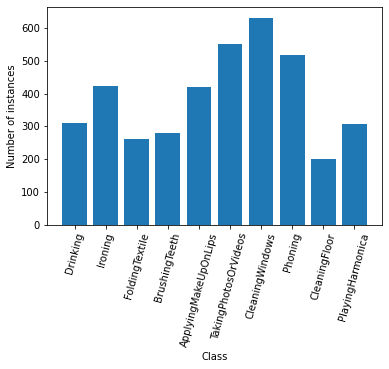

In [ ]:
# график распределения классов
import matplotlib.pyplot as plt
plt.bar(c.keys(), c.values())
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.xticks(rotation=75)

Задачу можно рассматривать как задачу регрессии(определение границ boundary box) и классификации(определить что внутри box)

В задаче классификации по графику видно, что классы не сбалансированы, а значит метрика accuracy_score не подходит. Лучше подойдет precision, recall, confusion matrix. В случае многоклассовой классификации можно использовать микро- или макро- усреднение.


Для определения правильности предсказания границ boundary box можно использовать метрику mean average precision (MAP) с усреднением по всем категориям 

In [10]:
vid='K6xXngYnVK8.mp4'
# количество кадров
len(daly['annot'][vid]['annot']['Drinking'][0]['keyframes'])

5

В видео есть инстанс или несколько инстансов и количество кадров от 1 до 5 на каждый инстанс. Каждый кадр описывается boundary box, pose,objects. И именно каждый кадр и подается на вход сети.

Датасет всего лишь разметка данных. Сами данные нужно скачать по меткам из daly['annot'].keys() и в соответствии с данными keyframes разбить на кадры

Для начала можно попробовать 2-x этапные методы (сначала определить регионы, а потом пройтись классификатором для определения меток классов). Например, можно использовать Faster R-CNN в from torchvision.models.detection import fasterrcnn_resnet50_fpn

В процессе обучения на вход сети подается Tensor([xmin,ymin,xmax,ymax]) xmin,ymin,xmax,ymax-размеры boundary box и каждому изображению внутри box сопоставляется label на выходе сети.

После настройки весов(веса настраиваются для минимизации loss) при валидации на вход подается кадр, на выходе box(xmin,ymin,xmax,ymax) и метка класса(предсказание того, что внутри box).

рассчитывается predict как процент правильных ответов классификатора и доля пересечений предсказанных bounding box с истинным положением